<a href="https://colab.research.google.com/github/Amitejashrout99/SuperconductivityPrediction/blob/main/ENPM_808W_Project_Initial_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
---
This notebook is a part of the two-notebook series which has been submitted as a part of the mid-term deliverable development done for the Project work. The project we as a group had selected was to perform an "analysis of superconductivity". While a detailed report will outline the highlights of this notebook, it seems prudent that the methodology is laid in the notebook so that the highlights presented in the report reflects the implementation of the methodology.  

# What does this Notebook actually cover?


---

This notebook reflects the efforts that were done to select the final features that will be used to train the predictive models or at-least reach a stage where it becomes easier to visualize what the final feature-set would look like and then proceed forward on that post the mid-term deliverable deadline.

Extending more on that information, this notebook performs the features-usefullness analysis(**not exploratory analysis**) and feature selection on the features that are present in the two dataset-files "train.csv" and "unique_m.csv". These files and their significance is laid out in the report.

By doing the feature-selection exercises for both of the dataset, we were able to get an basic idea about the *useful* features and *not-so-useful* features. Furthermore, we were also able to identify the various features that were giving us the best *R^2* scores for both of the dataset.

Additionally, this notebook also implements the various popular startegies of **feature_selection** that were taught in the class and other popular methods that are available in the popular _scikit-learn_ library such as _SelectFromModel_ and _RFECV_.

# Methodology
---
The methodology followed for the feature selection in both of the dataset-files follows a sequential process.
1. A "criteria" for pruning the features is selected. In this notebook, the various criterias used for pruning the features are **co-relation values of a feature**,**variance values of a feature** and **multicollinearity among the features**.  
2. For the first stage, the **co-relation values of a feature** is used for pruning the dataset. This is implemented by using a **Linear Regression** model to get the co-relation value of each criteria and based on the score the feature is selected. In this notebook, a feature is selected to be significant if the co-relation score is ```>0.5``` and ```<-0.5```.
3. Once the significant features are selected from the first stage, the subset of those features are selected from the features dataset which is further split into **Training** and **Testing** dataset. The reason for doing this is to evaluate whether the features together actually are significant in performing well.
4. The models used to perform this evaluation are **Linear Regression- used as a baseline**,**Polynomial Regression** and **Decision Tree Regression**.
5. Post the selection of feature on basis of **co-relation values of a feature**, **variance score of a feature** is taken into consideration. On basis of a _threshold_ value, the features are pruned and Step-3 and Step-4 are repeated again.
6. Once the **co-relation values of a feature** and **variance values of a feature** feature selection criterias are implemented, **multicollinearity among the features**. happens in a loop till all the features in the feature-dataset at-least have a multicollinearity ```<=20```.
7. For each iteration of the loop, the **VIF** of the features are calculated and based on a threshold level, the features are pruned and Step-3,4 are executed to get the next set of "feature-variables". This is done till the condition in Step-6 is reached.

Since, this methodology is designed by us to extract the best-feature, it can have flaws. To implement better-way of extracting features based on pre-implemented and tested startegies, we have also used the **[SelectFromModel](https://https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)** and **[RFECV](https://https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)** libraries to extract the useful features.


# So only Feature Selection so far and no Feature-Engineering ?
---
_Yes_ and _No_.

_Yes_,Since our dataset is made of features which are highly non-linear in nature and based on scientific properties, it'd difficult to formulate relationship without running into the risk of increasing the multicollinearity.

and _No_ because although not explicitly, we are using **Polynomial Regression** to generate new features at a higher polynomial space which is able to capture the non-linear relationship well among the data.

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Folder path in the drive where the dataset files are stored. Here the train.csv is just the name of the file and doesn't indicate that the presence of test.csv to be used. Additionally, the unique_m is another dataset file that we explored in the second part of this notebook.

In [34]:
! ls drive/MyDrive/ProjectDataset/
folder_path = "drive/MyDrive/ProjectDataset/"
training_file_path = "drive/MyDrive/ProjectDataset/train.csv"
unique_materials_file_path = "drive/MyDrive/ProjectDataset/unique_m.csv"

train.csv  unique_m.csv


Importing the necessary libraries

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#Importing the library which calculates the VIF for the relevant columns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
#Importing the SelectFromModel
from sklearn.feature_selection import SelectFromModel
#Importing Recursive Feature Selection with Cross Validation
from sklearn.feature_selection import RFECV
#Importing the Standard Scalar so that the features can be scaled.
from sklearn.preprocessing import StandardScaler

# Feature selection and analysis of the train.csv file

In [36]:
#Loading the training dataset
atomic_properties_df = pd.read_csv( filepath_or_buffer= training_file_path  )
#Printing the dataframe
print( atomic_properties_df.head() )
#Looks like there are 82 properties

   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607           

In [37]:
#Printing the dataframe properties
print( atomic_properties_df.info() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

In [38]:
#Printing the length of the model before dropping the duplicates
print( f"The length of the dataset before dropping the duplicates is { len(atomic_properties_df) }" )
#Dropping the duplicates
atomic_properties_df = atomic_properties_df.drop_duplicates()
#Printing the length of the model after dropping the duplicates
print( f"The length of the dataset after dropping the duplicates is { len( atomic_properties_df ) }" )

The length of the dataset before dropping the duplicates is 21263
The length of the dataset after dropping the duplicates is 21197


## Splitting the dataset into feature variables and response variable so that the pre-processing operation can be done on the features dataset without it affecting the response variable

In [39]:
atomic_properties_df_feature_variables = atomic_properties_df.drop( columns=["critical_temp"] )
#Printing the columns present in the new dataframe after taking the subset
print( atomic_properties_df_feature_variables.columns )
#Creating the Response Variable dataset by selecting the critical temperature from the dataset
atomic_properties_df_response_variable = atomic_properties_df[["critical_temp"]]

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

In [40]:
#Estimating the RMSE error obtained by training the model on all the features
#Before using the correlation filter, splitting the dataset into test and train dataset and checking the perfromance of the features selected by using the model.
atomic_properties_df_X_train, atomic_properties_df_X_test, atomic_properties_df_y_train, atomic_properties_df_y_test = train_test_split( atomic_properties_df_feature_variables, atomic_properties_df_response_variable, test_size=0.33, random_state=42 )
#Printing the shape of the training and testing dataset so as to ensure that everything is correct
print( f"The shape of the feature variable in the training dataset is {atomic_properties_df_X_train.shape}" )
print( f"The shape of the response variable in the training dataset is {atomic_properties_df_y_train.shape}")
print( f"The shape of the feature variable in the testing dataset is {atomic_properties_df_X_test.shape}" )
print( f"The shape of the response variable in the testing dataset is {atomic_properties_df_y_test.shape}")

The shape of the feature variable in the training dataset is (14201, 81)
The shape of the response variable in the training dataset is (14201, 1)
The shape of the feature variable in the testing dataset is (6996, 81)
The shape of the response variable in the testing dataset is (6996, 1)


In [41]:
#Fitting the model on the Linear Regression and trying to get the RMSE score on the test dataset
linearRegressionModel = LinearRegression()
#Training the model
linearRegressionModel.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions
linearModelPredictions = linearRegressionModel.predict( atomic_properties_df_X_test )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( linearModelPredictions, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 17.640477782341474


In [42]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( linearModelPredictions, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.6406422478369597


[-2.86, 0.92, -0.95, -0.57, 0.68, -32.33, 1.44, 0.2, 0.03, -0.52, 0.08, 0.19, -0.2, -0.19, 0.22, -113.58, 37.27, 0.06, 0.02, -0.19, -0.01, -0.38, 3.0, 0.02, -2.58, 61.35, 46.76, 0.21, -0.1, -0.43, -0.29, -0.01, 0.0, 0.0, 0.0, 20.44, -20.29, -0.0, -0.0, 0.01, -0.0, -0.07, 0.55, 0.17, -0.61, 5.29, -23.2, -0.4, -0.15, 1.32, -0.56, 1.61, -1.87, -1.38, 1.5, -20.36, 25.18, -0.31, 0.62, -0.7, 0.73, -0.08, 0.52, -0.06, -0.32, 12.51, 1.37, -0.09, -0.23, 0.29, -0.01, -15.45, 26.9, 19.8, -31.24, 80.2, -63.09, 4.75, -0.09, 7.1, -25.44]


<Axes: title={'center': 'Bar-graph showing the coefficients values for each column recieved from the linear regression of the columns in the feature dataset'}>

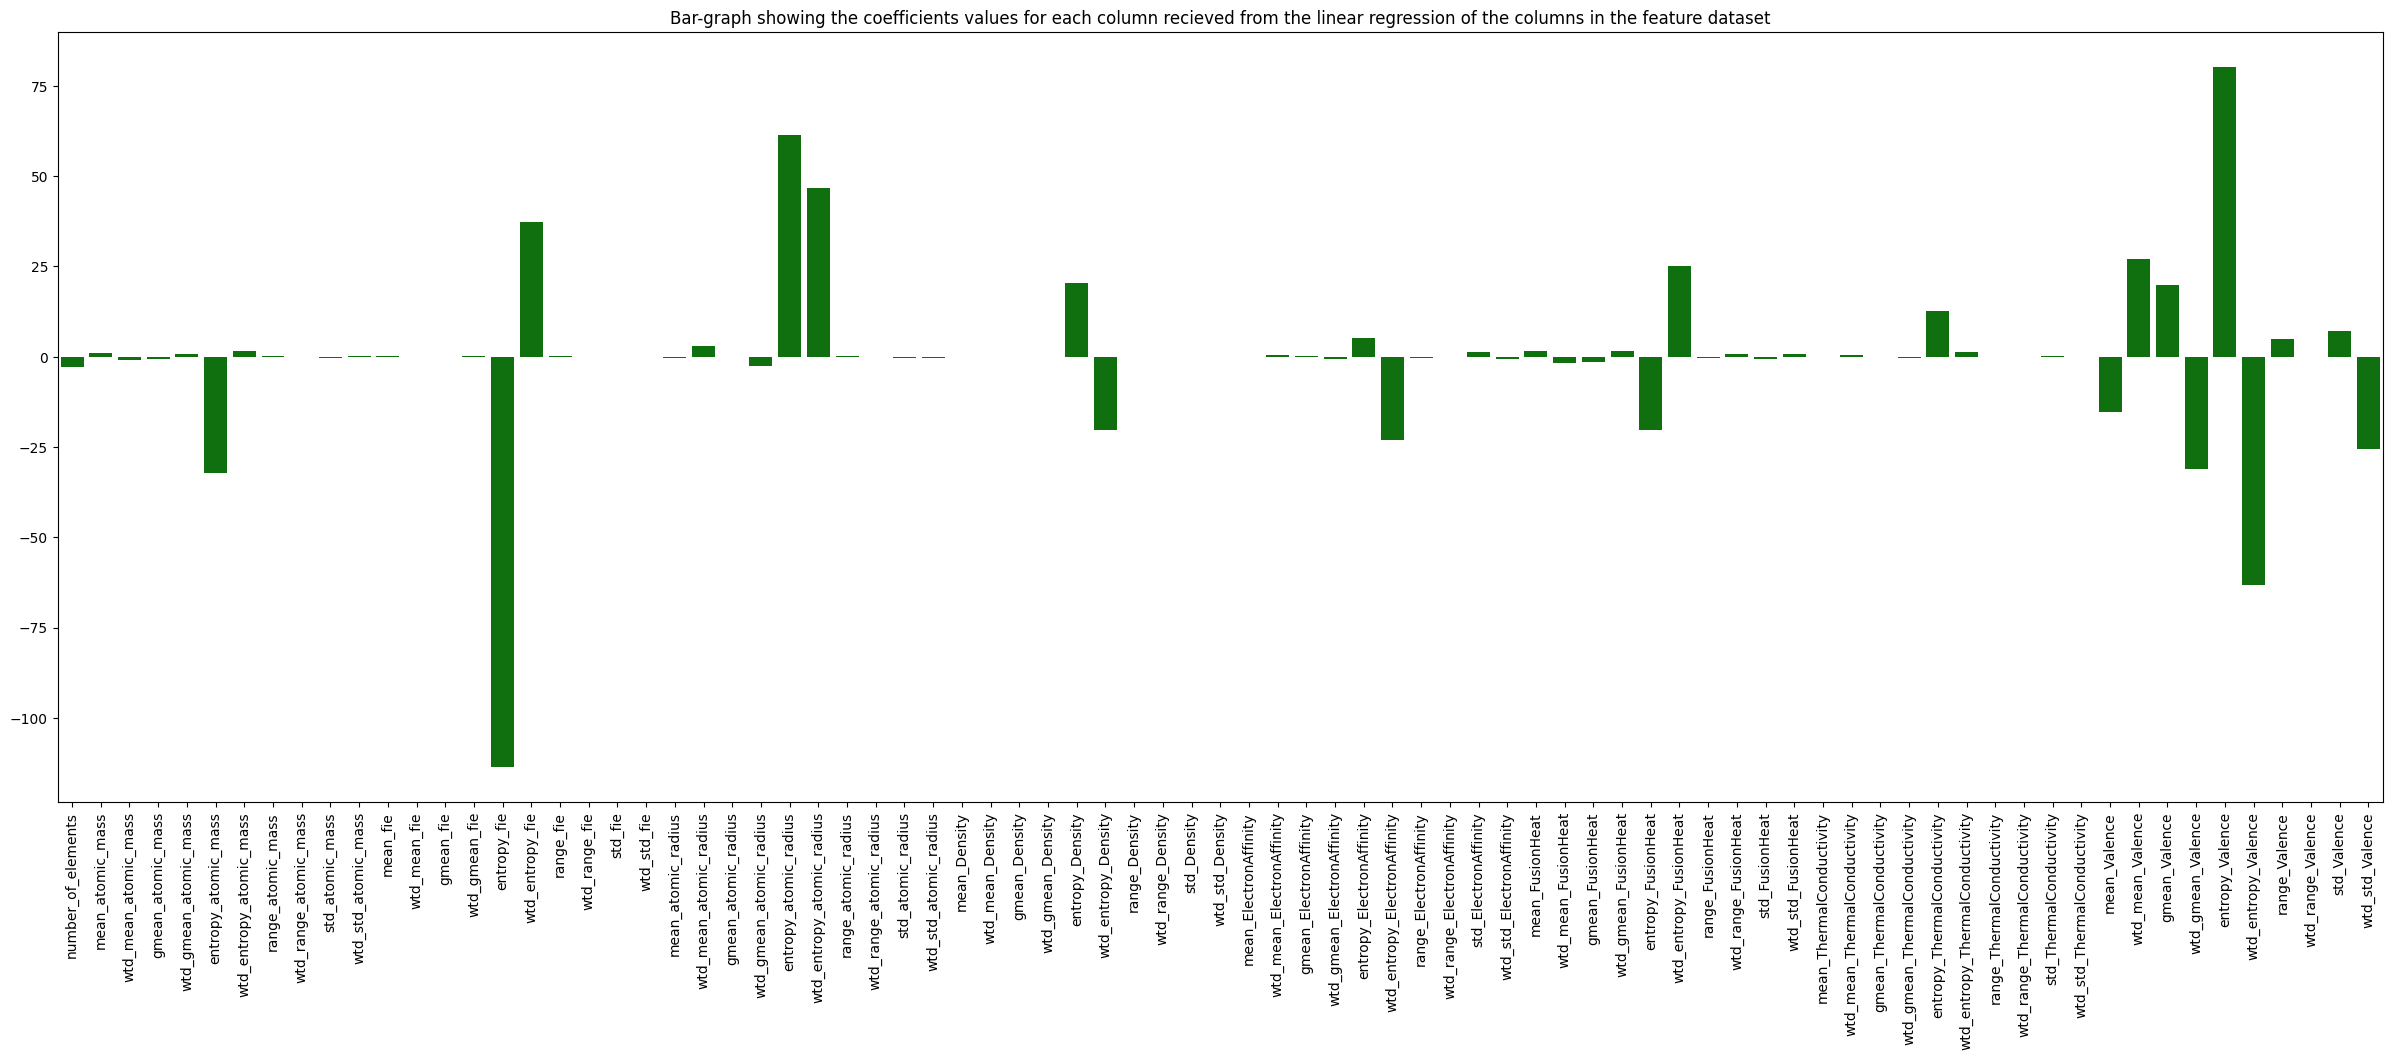

In [43]:
#Extracting the coefficient values of the linear regression model
coefficients_linear_regression = linearRegressionModel.coef_[0]
coefficients_linear_regression = [ float( "{:.2f}".format( x ) ) for x in coefficients_linear_regression ]
#Printing the coefficients of the linear regression model
print( coefficients_linear_regression )
#Plotting the coeffiecients in form of a bar-graph
plt.figure( figsize = ( 30,10 ) )
plt.title( "Bar-graph showing the coefficients values for each column recieved from the linear regression of the columns in the feature dataset" )
plt.xticks( ticks = np.arange( 0, len( coefficients_linear_regression ), step = 1  ), labels = atomic_properties_df_feature_variables.columns.values, rotation='vertical')
#Plotting the bar-plot
sns.barplot( x = atomic_properties_df_feature_variables.columns.values , y = coefficients_linear_regression, color = "green" )

Looking from the coefficient values, we can notice that the columns with the "entropy" feature attached to it plays a very important role in co-relating with the "critical temperature". It can be seen that majority of the features don't play an important role in correlating with the target column. For the next round of feature selection, may-be we can select these features only who have a significant value of co-relation whether it may be negative or positive.

In [44]:
#Getting the indexes of the features who have at least > +0.5 co-relation value and < -0.5 co-realtion value
first_filter_significant_columns = []
for coefficients, column in zip( coefficients_linear_regression, atomic_properties_df_feature_variables.columns.values.tolist() ):
  if( coefficients >= 0.5 or coefficients <= -0.5 ):
    first_filter_significant_columns.append( column )
#Printing the significant_columns length
print( f"The number of significantly co-related columns are { len( first_filter_significant_columns ) }" )
#Printing the significant columns
print( first_filter_significant_columns )

The number of significantly co-related columns are 43
['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass', 'wtd_entropy_atomic_mass', 'std_atomic_mass', 'entropy_fie', 'wtd_entropy_fie', 'wtd_mean_atomic_radius', 'wtd_gmean_atomic_radius', 'entropy_atomic_radius', 'wtd_entropy_atomic_radius', 'entropy_Density', 'wtd_entropy_Density', 'wtd_mean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'entropy_ElectronAffinity', 'wtd_entropy_ElectronAffinity', 'std_ElectronAffinity', 'wtd_std_ElectronAffinity', 'mean_FusionHeat', 'wtd_mean_FusionHeat', 'gmean_FusionHeat', 'wtd_gmean_FusionHeat', 'entropy_FusionHeat', 'wtd_entropy_FusionHeat', 'wtd_range_FusionHeat', 'std_FusionHeat', 'wtd_std_FusionHeat', 'wtd_mean_ThermalConductivity', 'entropy_ThermalConductivity', 'wtd_entropy_ThermalConductivity', 'mean_Valence', 'wtd_mean_Valence', 'gmean_Valence', 'wtd_gmean_Valence', 'entropy_Valence', 'wtd_entropy_Valence'

In [45]:
#Taking the subset of these features from the model and running the Linear Regression Model
atomic_properties_df_feature_variables = atomic_properties_df_feature_variables[ first_filter_significant_columns ]
#Printing the feature variables dataset
print( atomic_properties_df_feature_variables.head() )

   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  std_atomic_mass  entropy_fie  wtd_entropy_fie  \
0                 1.062396        51.968828     1.305967         0.791488   
1                 1.057755        47.094633   

## Testing the performance of the various models using the features that were considered as relevant/useful after using the *co-relation* scores as criteria.

In [46]:
atomic_properties_df_X_train, atomic_properties_df_X_test, atomic_properties_df_y_train, atomic_properties_df_y_test = train_test_split( atomic_properties_df_feature_variables, atomic_properties_df_response_variable, test_size=0.33, random_state=42 )
#Printing the shape of the training and testing dataset so as to ensure that everything is correct
print( f"The shape of the feature variable in the training dataset is {atomic_properties_df_X_train.shape}" )
print( f"The shape of the response variable in the training dataset is {atomic_properties_df_y_train.shape}")
print( f"The shape of the feature variable in the testing dataset is {atomic_properties_df_X_test.shape}" )
print( f"The shape of the response variable in the testing dataset is {atomic_properties_df_y_test.shape}")

The shape of the feature variable in the training dataset is (14201, 43)
The shape of the response variable in the training dataset is (14201, 1)
The shape of the feature variable in the testing dataset is (6996, 43)
The shape of the response variable in the testing dataset is (6996, 1)


## Linear Regression Model to predict the performance of the ```43``` columns obtained.

In [47]:
#Fitting the model on the Linear Regression and trying to get the RMSE score on the test dataset
linearRegressionModel = LinearRegression()
#Training the model
linearRegressionModel.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions
linearModelPredictions = linearRegressionModel.predict( atomic_properties_df_X_test )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( linearModelPredictions, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 19.495094557500536


In [48]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( linearModelPredictions, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.5214582724865184


## Decision Tree Regressor to predict the performance of the 43 columns obained.

In [50]:
#Using a Decision Tree Regressor to predict so that we can get the best scores
decisionTreeRegressor = DecisionTreeRegressor()
#Training the model
decisionTreeRegressor.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions from the decision Tree Regressor
predictions_decision_tree_regressor = decisionTreeRegressor.predict( atomic_properties_df_X_test )
##Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( predictions_decision_tree_regressor, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 12.276831611544532


In [51]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( predictions_decision_tree_regressor, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.8710232506802371


## Polynomial decision tree Regressor to predict the performance of the ```43``` columns obtained.

In [52]:
#Since our features are not linearly related, let's try polynomial regression
polynomialFeatures = PolynomialFeatures( degree = 2, include_bias=False )
#Fitting the polynomial feaures onto the training features dataset
atomic_properties_df_X_train = polynomialFeatures.fit_transform( atomic_properties_df_X_train )
#Fitting the polynomial features onto the testing features dataset
atomic_properties_df_X_test = polynomialFeatures.fit_transform( atomic_properties_df_X_test )
#Creating a object of the Linear Regression that will train on these properties
linearRegressionModel = LinearRegression()
#Training the model
linearRegressionModel.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions output from the model
linearModelPredictions = linearRegressionModel.predict( atomic_properties_df_X_test )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( linearModelPredictions, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 14.688463204079987


In [53]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( linearModelPredictions, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.7891044054727749


Since from the initial exploratory analysis, it was proved that the features in general don't share Linear Relationship with Critical Temperature, therefore it was prudent to explore the Quadratic Relationship among the features using Polynomial Features

## Exploring the distribution of the variance among the 43 features that we used

In [73]:
#Getting the variance values
variance_values_after_filtering = atomic_properties_df_feature_variables.var()
#Converting the variance values to dataframe
variance_values_after_filtering_df = variance_values_after_filtering.to_frame( name = "variance_factor" )
#Resetting the index so that the index gets converted into columns
variance_values_after_filtering_df = variance_values_after_filtering_df.reset_index( level = 0 )
#Changing the name of the column from "index" to the "feature_name"
variance_values_after_filtering_df = variance_values_after_filtering_df.rename( columns = {"index":"feature_name"} )
#Printing the variance value after converting it into a dataframe
print( variance_values_after_filtering_df.head(100) )

                       feature_name  variance_factor
0                number_of_elements         2.068656
1                  mean_atomic_mass       878.715517
2              wtd_mean_atomic_mass      1119.624368
3                 gmean_atomic_mass       960.428050
4             wtd_gmean_atomic_mass      1340.686111
5               entropy_atomic_mass         0.133015
6           wtd_entropy_atomic_mass         0.160982
7                   std_atomic_mass       400.789676
8                       entropy_fie         0.145616
9                   wtd_entropy_fie         0.111627
10           wtd_mean_atomic_radius       828.139239
11          wtd_gmean_atomic_radius      1281.721149
12            entropy_atomic_radius         0.140706
13        wtd_entropy_atomic_radius         0.165548
14                  entropy_Density         0.117192
15              wtd_entropy_Density         0.102277
16        wtd_mean_ElectronAffinity      1042.144127
17       wtd_gmean_ElectronAffinity      1002.

### Plotting the distribution of the variance values in form of a bar-graph

<Axes: title={'center': 'Plotting the variance of the features among the 43 columns'}, xlabel='feature_name', ylabel='variance_factor'>

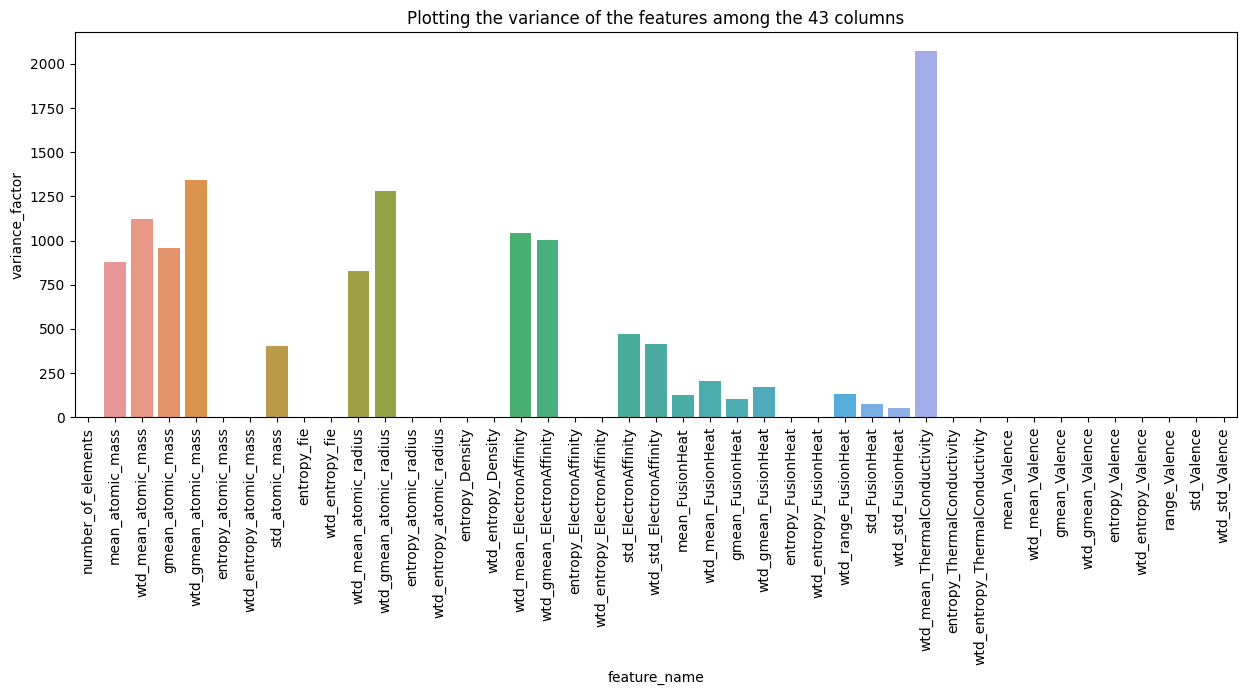

In [72]:
plt.figure( figsize = ( 15,5 ) )
plt.title( "Plotting the variance of the features among the 43 columns" )
#Setting the x-ticks
plt.xticks( ticks = np.arange(0, len( atomic_properties_df_feature_variables.columns.values ), step=1), labels = atomic_properties_df_feature_variables.columns.values, rotation = 'vertical' )
#Plotting the graph
sns.barplot( data = variance_values_after_filtering_df , x = "feature_name", y = "variance_factor" )

### Extracting the column names whose variance value is less than ```1```.  

Once, the features-names are extracted whose variance values is less than 1, the **VIF** is calculated among those feature names

In [76]:
features_names_with_variance_factor_greater_than_fifty = variance_values_after_filtering_df[(variance_values_after_filtering_df["variance_factor"] >= 50)]["feature_name"].values.tolist()
#Printing the length of features_names
print( "The features left with after taking the variance into factor is " )
print( len(features_names_with_variance_factor_greater_than_fifty ) )
#Printing the features names
print( "The features names are " )
print( features_names_with_variance_factor_greater_than_fifty )

The features left with after taking the variance into factor is 
19
The features names are 
['mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'std_atomic_mass', 'wtd_mean_atomic_radius', 'wtd_gmean_atomic_radius', 'wtd_mean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'std_ElectronAffinity', 'wtd_std_ElectronAffinity', 'mean_FusionHeat', 'wtd_mean_FusionHeat', 'gmean_FusionHeat', 'wtd_gmean_FusionHeat', 'wtd_range_FusionHeat', 'std_FusionHeat', 'wtd_std_FusionHeat', 'wtd_mean_ThermalConductivity']


## Updating the feature-variables columns with the name of the features that we selected after variance analysis

In [77]:
atomic_properties_df_feature_variables = atomic_properties_df_feature_variables[ features_names_with_variance_factor_greater_than_fifty ]

## Performing the next round of the feature-selection by calculating the VIF or the Variance-Inflation Factor among the features that were selected after the last-round of the selection

It should be noted that, we are adding a constant column to the code to calculate the VIF as the used Variance-Inflation Factor library of the statsmodel is not able to calculate the VIF is there isn't a constant in the library. This is apparently a known bug that was dicussed and a Github issue was created by the author of the library. The [discussion](https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python) and the [github issue thread](https://https://github.com/statsmodels/statsmodels/issues/2376) are linked.



In [78]:
#Adding a constant column so that we can get the actual VIF factor as the VIF factor assumes a constant in the calculation
#atomic_properties_filtered.loc[:,"constant_column"] = 1
#Printing the column values
atomic_properties_df_feature_variables_constant = add_constant( atomic_properties_df_feature_variables )
#Printing the columns in the constant_columns
print( atomic_properties_df_feature_variables_constant.info() )
atomic_properties_multicollinear = pd.Series([variance_inflation_factor(  atomic_properties_df_feature_variables_constant.values, i)
for i in range(  atomic_properties_df_feature_variables_constant.shape[1])],
              index=atomic_properties_df_feature_variables_constant.columns)
#Printing the series
print( atomic_properties_multicollinear )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21197 entries, 0 to 21262
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   const                         21197 non-null  float64
 1   mean_atomic_mass              21197 non-null  float64
 2   wtd_mean_atomic_mass          21197 non-null  float64
 3   gmean_atomic_mass             21197 non-null  float64
 4   wtd_gmean_atomic_mass         21197 non-null  float64
 5   std_atomic_mass               21197 non-null  float64
 6   wtd_mean_atomic_radius        21197 non-null  float64
 7   wtd_gmean_atomic_radius       21197 non-null  float64
 8   wtd_mean_ElectronAffinity     21197 non-null  float64
 9   wtd_gmean_ElectronAffinity    21197 non-null  float64
 10  std_ElectronAffinity          21197 non-null  float64
 11  wtd_std_ElectronAffinity      21197 non-null  float64
 12  mean_FusionHeat               21197 non-null  float64
 13  w

### Converting the variance factor to a dataframe

In [87]:
#Converting the multicollinear properties to a dataframe and plotting the results in form of a bar-graph
atomic_properties_multicollinear_df = atomic_properties_multicollinear.to_frame( name = "VIF_value" )
#Resetting the index so as to create a new dataframe with the updated results
atomic_properties_multicollinear_df = atomic_properties_multicollinear_df.reset_index( level = 0 )
#Changing the column name
atomic_properties_multicollinear_df = atomic_properties_multicollinear_df.rename( columns={ "index":"column_name" } )
#Printing the dataframe after creating the dataframe
print( atomic_properties_multicollinear_df.head(20) )

                     column_name   VIF_value
0                          const  120.964155
1               mean_atomic_mass   93.170760
2           wtd_mean_atomic_mass   75.911807
3              gmean_atomic_mass  103.371506
4          wtd_gmean_atomic_mass  107.775358
5                std_atomic_mass    7.722954
6         wtd_mean_atomic_radius   52.905128
7        wtd_gmean_atomic_radius   72.720357
8      wtd_mean_ElectronAffinity   36.555141
9     wtd_gmean_ElectronAffinity   26.903069
10          std_ElectronAffinity    6.622296
11      wtd_std_ElectronAffinity   14.500999
12               mean_FusionHeat  201.621473
13           wtd_mean_FusionHeat  319.195386
14              gmean_FusionHeat  147.357672
15          wtd_gmean_FusionHeat  255.860884
16          wtd_range_FusionHeat   10.938511
17                std_FusionHeat   66.328898
18            wtd_std_FusionHeat   46.366292
19  wtd_mean_ThermalConductivity    1.338605


### Creating a bar-plot showing the VIF vaues

<Axes: title={'center': 'Bar-graph showing the variance_factor of the columns in the feature dataset'}, xlabel='column_name', ylabel='VIF_value'>

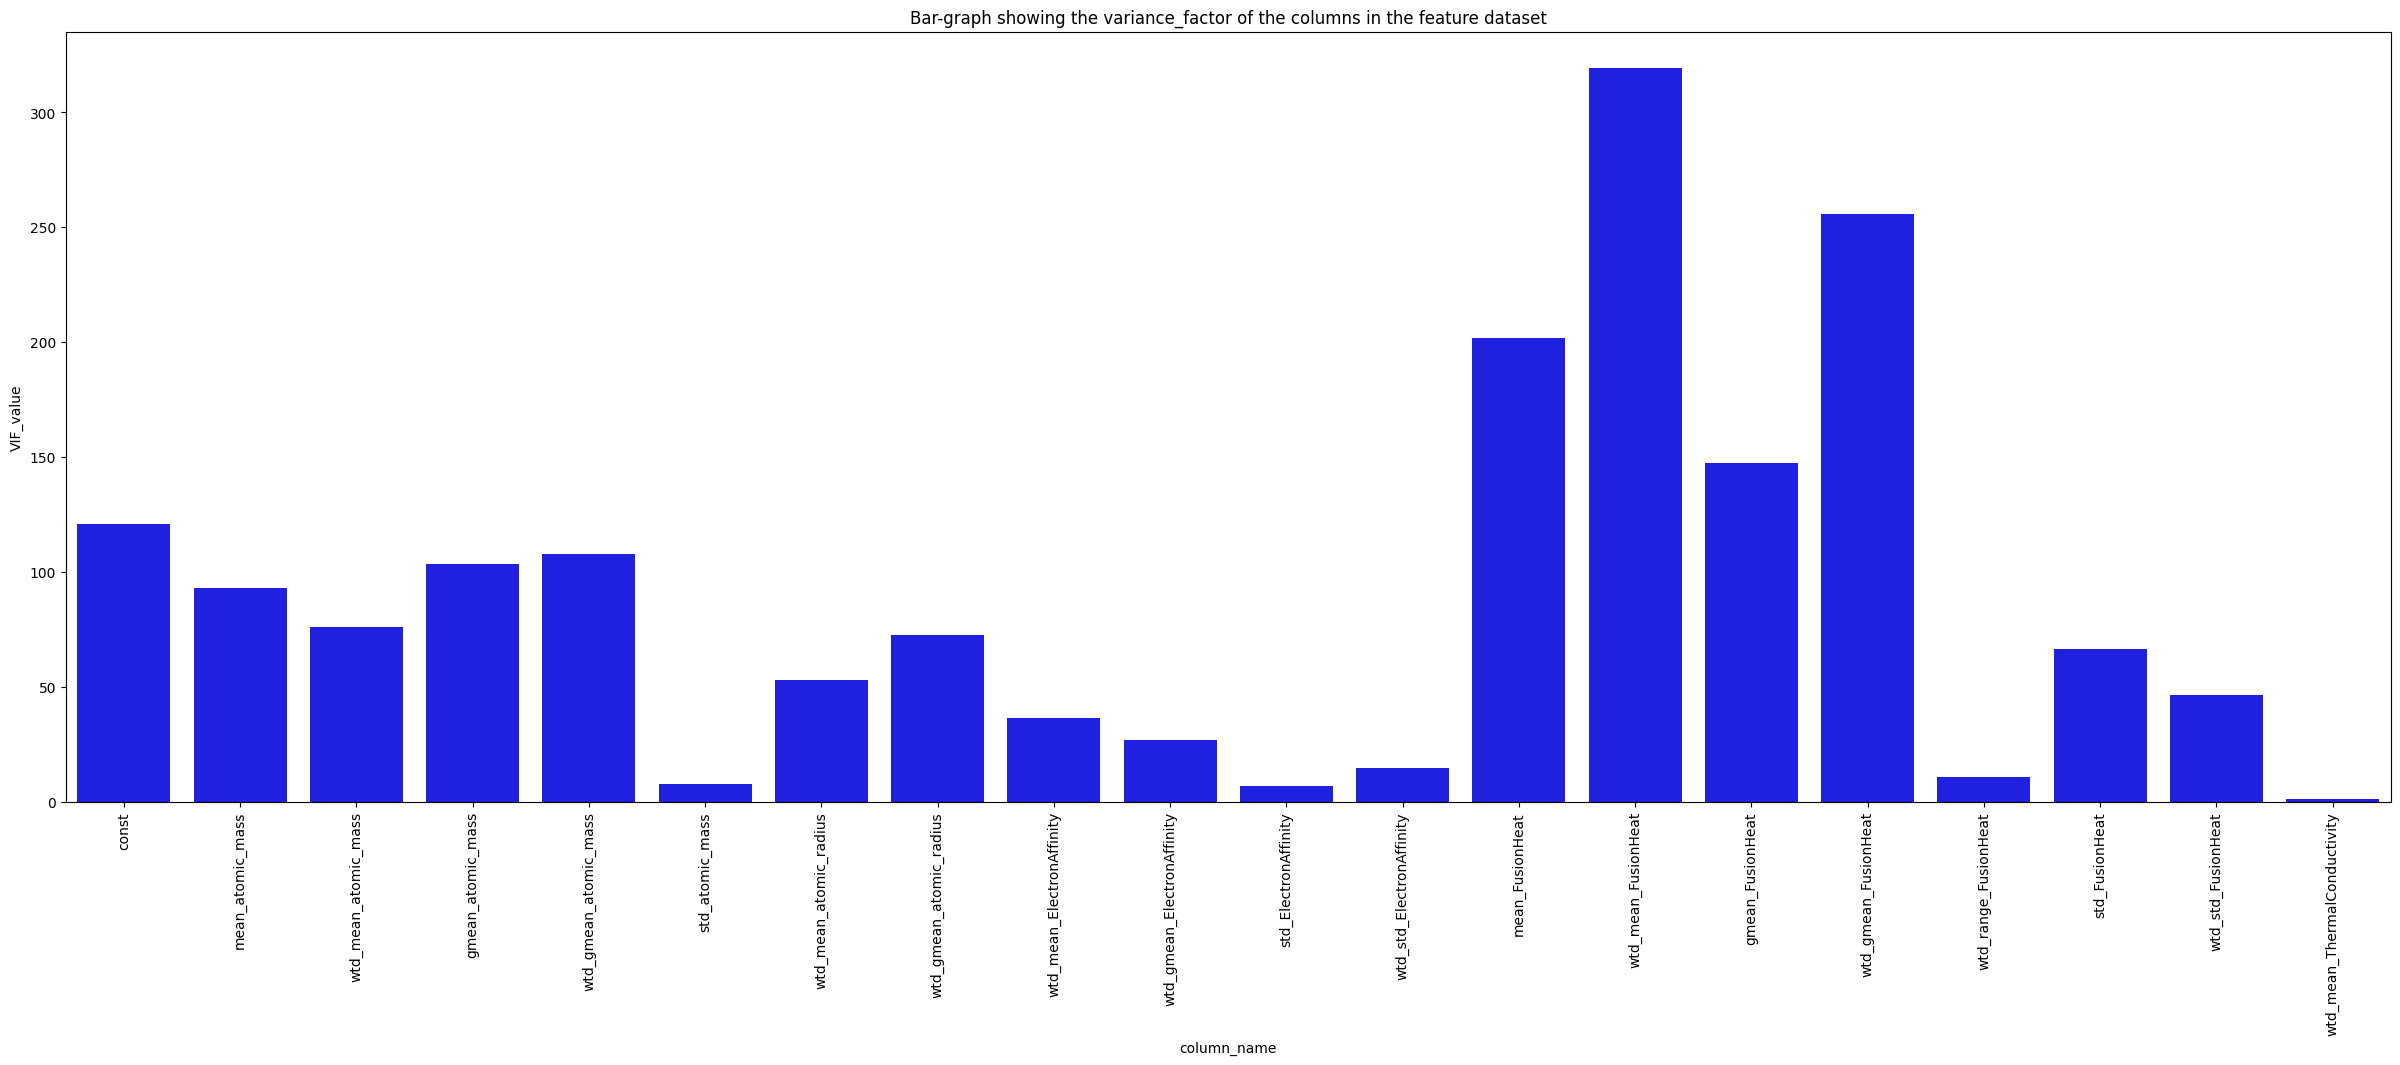

In [88]:
#Plotting the variance factor in form of a bar-graph so that we can identify which column_name should be dropped after the first round of the filtering
plt.figure( figsize = ( 30,10 ) )
plt.title( "Bar-graph showing the variance_factor of the columns in the feature dataset" )
#Limiting the y axis to 100 so that we can get a better idea
#plt.ylim( 0, 2000 )
plt.xticks(np.arange(0,len( atomic_properties_multicollinear_df["column_name"].values ),step=1), atomic_properties_multicollinear_df["column_name"].values , rotation='vertical')
sns.barplot( data = atomic_properties_multicollinear_df , x= "column_name" , y = "VIF_value" , color = 'blue')

### Dropping all the features where the **VIF_values** is above 100. By dropping high variance values, we are able to obtain two results; one is that the multicollinearity decreases and second is that the variance values of other variables decreases as well.

In [89]:
#Dropping all the features which have a very high VIF factor above 100 and analyzing the variance_factor
atomic_properties_multicollinear_df = atomic_properties_multicollinear_df[( atomic_properties_multicollinear_df["VIF_value"] < 100 )]
#Getting the list of all the columns in the dataframe
columns_names_atomic_properties_multicollinear_df = atomic_properties_multicollinear_df["column_name"].values.tolist()
#Printing the column names
print( columns_names_atomic_properties_multicollinear_df )
#Getting all the feature columns from the multicollinear df and taking the subset of those column from the features column
atomic_properties_df_feature_variables = atomic_properties_df_feature_variables[ columns_names_atomic_properties_multicollinear_df ]
#Printing the length of the columns after taking the subset
print( f"The length of the subset after dropping the dataset is { len( atomic_properties_df_feature_variables.columns ) }" )
#Printing the columns present in the new dataframe after taking the subset
print( atomic_properties_df_feature_variables.columns )

['mean_atomic_mass', 'wtd_mean_atomic_mass', 'std_atomic_mass', 'wtd_mean_atomic_radius', 'wtd_gmean_atomic_radius', 'wtd_mean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'std_ElectronAffinity', 'wtd_std_ElectronAffinity', 'wtd_range_FusionHeat', 'std_FusionHeat', 'wtd_std_FusionHeat', 'wtd_mean_ThermalConductivity']
The length of the subset after dropping the dataset is 13
Index(['mean_atomic_mass', 'wtd_mean_atomic_mass', 'std_atomic_mass',
       'wtd_mean_atomic_radius', 'wtd_gmean_atomic_radius',
       'wtd_mean_ElectronAffinity', 'wtd_gmean_ElectronAffinity',
       'std_ElectronAffinity', 'wtd_std_ElectronAffinity',
       'wtd_range_FusionHeat', 'std_FusionHeat', 'wtd_std_FusionHeat',
       'wtd_mean_ThermalConductivity'],
      dtype='object')


### Testing the performance of the model on the 13 features that were selected after the multicollinearity testing where only those features are selected whose VIF_value is ```<100```

In [90]:
atomic_properties_df_X_train, atomic_properties_df_X_test, atomic_properties_df_y_train, atomic_properties_df_y_test = train_test_split( atomic_properties_df_feature_variables, atomic_properties_df_response_variable, test_size=0.33, random_state=42 )
#Printing the shape of the training and testing dataset so as to ensure that everything is correct
print( f"The shape of the feature variable in the training dataset is {atomic_properties_df_X_train.shape}" )
print( f"The shape of the response variable in the training dataset is {atomic_properties_df_y_train.shape}")
print( f"The shape of the feature variable in the testing dataset is {atomic_properties_df_X_test.shape}" )
print( f"The shape of the response variable in the testing dataset is {atomic_properties_df_y_test.shape}")

The shape of the feature variable in the training dataset is (14201, 13)
The shape of the response variable in the training dataset is (14201, 1)
The shape of the feature variable in the testing dataset is (6996, 13)
The shape of the response variable in the testing dataset is (6996, 1)


## Linear Regression Model to predict the performance of the model using ```13``` features selected from **VIF_Value** feature-selection criteria.

In [91]:
#Fitting the model on the Linear Regression and trying to get the RMSE score on the test dataset
linearRegressionModel = LinearRegression()
#Training the model
linearRegressionModel.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions
linearModelPredictions = linearRegressionModel.predict( atomic_properties_df_X_test )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( linearModelPredictions, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 21.67760097382497


In [92]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( linearModelPredictions, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.34111948209688825


## Decision Tree Regressor to predict the performance of the model using the ```13``` values selected from the **VIF_Value** feature-selection criteria

In [93]:
#Using a Decision Tree Regressor to predict so that we can get the best scores
decisionTreeRegressor = DecisionTreeRegressor()
#Training the model
decisionTreeRegressor.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions from the decision Tree Regressor
predictions_decision_tree_regressor = decisionTreeRegressor.predict( atomic_properties_df_X_test )
##Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( predictions_decision_tree_regressor, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 13.455964136797734


In [94]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( predictions_decision_tree_regressor, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.8442397123545644


## Polynomial Regressor to predict the performance of the model using the **13** values selected from the **VIF_Value** feature selection criteria.

In [95]:
#Since our features are not linearly related, let's try polynomial regression
polynomialFeatures = PolynomialFeatures( degree = 2, include_bias=False )
#Fitting the polynomial feaures onto the training features dataset
atomic_properties_df_X_train = polynomialFeatures.fit_transform( atomic_properties_df_X_train )
#Fitting the polynomial features onto the testing features dataset
atomic_properties_df_X_test = polynomialFeatures.fit_transform( atomic_properties_df_X_test )
#Creating a object of the Linear Regression that will train on these properties
linearRegressionModel = LinearRegression()
#Training the model
linearRegressionModel.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions output from the model
linearModelPredictions = linearRegressionModel.predict( atomic_properties_df_X_test )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( linearModelPredictions, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 17.113077529009587


In [96]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( linearModelPredictions, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.6730516477168682


## Another round of VIF calculation to check if there are still any multi-collinear variable

In [97]:
#Adding a constant column so that we can get the actual VIF factor as the VIF factor assumes a constant in the calculation
#atomic_properties_filtered.loc[:,"constant_column"] = 1
#Printing the column values
atomic_properties_df_feature_variables_constant = add_constant( atomic_properties_df_feature_variables )
#Printing the columns in the constant_columns
print( atomic_properties_df_feature_variables_constant.info() )
atomic_properties_multicollinear = pd.Series([variance_inflation_factor(  atomic_properties_df_feature_variables_constant.values, i)
for i in range(  atomic_properties_df_feature_variables_constant.shape[1])],
              index=atomic_properties_df_feature_variables_constant.columns)
#Printing the series
print( atomic_properties_multicollinear )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21197 entries, 0 to 21262
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   const                         21197 non-null  float64
 1   mean_atomic_mass              21197 non-null  float64
 2   wtd_mean_atomic_mass          21197 non-null  float64
 3   std_atomic_mass               21197 non-null  float64
 4   wtd_mean_atomic_radius        21197 non-null  float64
 5   wtd_gmean_atomic_radius       21197 non-null  float64
 6   wtd_mean_ElectronAffinity     21197 non-null  float64
 7   wtd_gmean_ElectronAffinity    21197 non-null  float64
 8   std_ElectronAffinity          21197 non-null  float64
 9   wtd_std_ElectronAffinity      21197 non-null  float64
 10  wtd_range_FusionHeat          21197 non-null  float64
 11  std_FusionHeat                21197 non-null  float64
 12  wtd_std_FusionHeat            21197 non-null  float64
 13  w

It can be seen that there are still multicollinear variables, hence removing the properties that are below 20

In [101]:
#Converting the multicollinear properties to a dataframe and plotting the results in form of a bar-graph
atomic_properties_multicollinear_df = atomic_properties_multicollinear.to_frame( name = "VIF_value" )
#Resetting the index so as to create a new dataframe with the updated results
atomic_properties_multicollinear_df = atomic_properties_multicollinear_df.reset_index( level = 0 )
#Changing the column name
atomic_properties_multicollinear_df = atomic_properties_multicollinear_df.rename( columns={ "index":"column_name" } )
#Printing the dataframe after creating the dataframe
print( atomic_properties_multicollinear_df.head() )

              column_name   VIF_value
0                   const  118.923690
1        mean_atomic_mass    4.654954
2    wtd_mean_atomic_mass    6.626975
3         std_atomic_mass    1.726201
4  wtd_mean_atomic_radius   37.685302


<Axes: title={'center': 'Bar-graph showing the variance_factor of the columns in the feature dataset'}, xlabel='column_name', ylabel='VIF_value'>

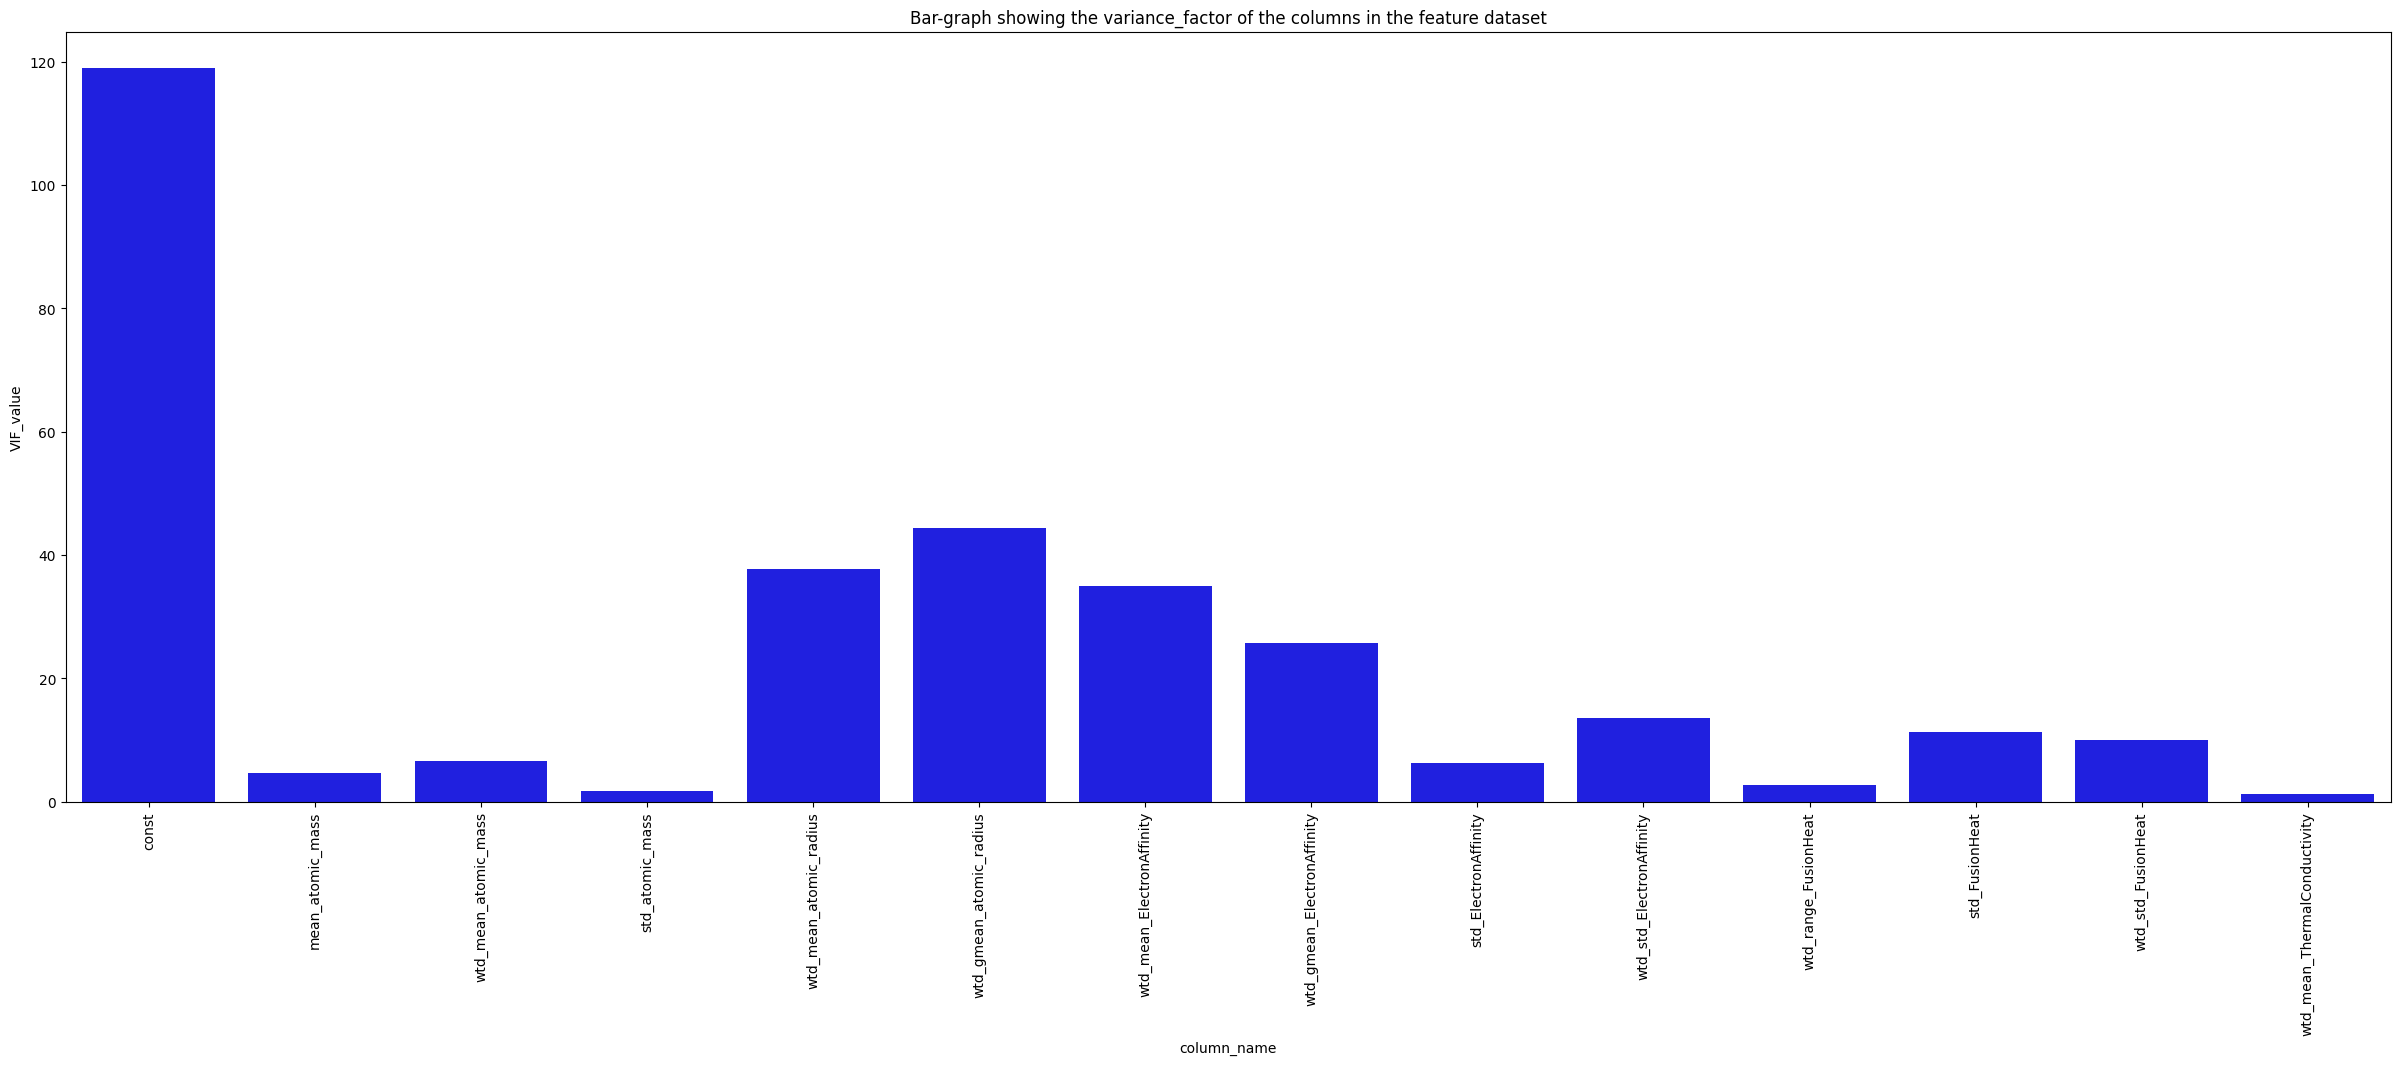

In [102]:
#Plotting the variance factor in form of a bar-graph so that we can identify which column_name should be dropped after the first round of the filtering
plt.figure( figsize = ( 30,10 ) )
plt.title( "Bar-graph showing the variance_factor of the columns in the feature dataset" )
plt.xticks(np.arange(0,len( atomic_properties_multicollinear_df["column_name"].values ),step=1), atomic_properties_multicollinear_df["column_name"].values , rotation='vertical')
sns.barplot( data = atomic_properties_multicollinear_df , x= "column_name" , y = "VIF_value" , color = 'blue')

In [103]:
#Dropping all the features which have a very high VIF factor above 20 and analyzing the variance_factor
atomic_properties_multicollinear_df = atomic_properties_multicollinear_df[( atomic_properties_multicollinear_df["VIF_value"] <= 20 )]
#Getting the list of all the columns in the dataframe
columns_names_atomic_properties_multicollinear_df = atomic_properties_multicollinear_df["column_name"].values.tolist()
#Printing the column names
print( columns_names_atomic_properties_multicollinear_df )
#Getting all the feature columns from the multicollinear df and taking the subset of those column from the features column
atomic_properties_df_feature_variables = atomic_properties_df_feature_variables[ columns_names_atomic_properties_multicollinear_df ]
#Printing the length of the columns after taking the subset
print( f"The length of the subset after dropping the dataset is { len( atomic_properties_df_feature_variables.columns ) }" )
#Printing the columns present in the new dataframe after taking the subset
print( atomic_properties_df_feature_variables.columns )

['mean_atomic_mass', 'wtd_mean_atomic_mass', 'std_atomic_mass', 'std_ElectronAffinity', 'wtd_std_ElectronAffinity', 'wtd_range_FusionHeat', 'std_FusionHeat', 'wtd_std_FusionHeat', 'wtd_mean_ThermalConductivity']
The length of the subset after dropping the dataset is 9
Index(['mean_atomic_mass', 'wtd_mean_atomic_mass', 'std_atomic_mass',
       'std_ElectronAffinity', 'wtd_std_ElectronAffinity',
       'wtd_range_FusionHeat', 'std_FusionHeat', 'wtd_std_FusionHeat',
       'wtd_mean_ThermalConductivity'],
      dtype='object')


## Splitting the dataset to create the training and testing dataset so that the performance of the models can be evaluated.

In [104]:
atomic_properties_df_X_train, atomic_properties_df_X_test, atomic_properties_df_y_train, atomic_properties_df_y_test = train_test_split( atomic_properties_df_feature_variables, atomic_properties_df_response_variable, test_size=0.33, random_state=42 )
#Printing the shape of the training and testing dataset so as to ensure that everything is correct
print( f"The shape of the feature variable in the training dataset is {atomic_properties_df_X_train.shape}" )
print( f"The shape of the response variable in the training dataset is {atomic_properties_df_y_train.shape}")
print( f"The shape of the feature variable in the testing dataset is {atomic_properties_df_X_test.shape}" )
print( f"The shape of the response variable in the testing dataset is {atomic_properties_df_y_test.shape}")

The shape of the feature variable in the training dataset is (14201, 9)
The shape of the response variable in the training dataset is (14201, 1)
The shape of the feature variable in the testing dataset is (6996, 9)
The shape of the response variable in the testing dataset is (6996, 1)


## Linear Regression to predict the performance of the model using the ```9``` values selected from the **VIF_Value** feature-selection criteria

In [105]:
#Fitting the model on the Linear Regression and trying to get the RMSE score on the test dataset
linearRegressionModel = LinearRegression()
#Training the model
linearRegressionModel.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions
linearModelPredictions = linearRegressionModel.predict( atomic_properties_df_X_test )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( linearModelPredictions, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 25.246862674445122


In [106]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( linearModelPredictions, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is -0.18737825584153955


## Decision Tree Regressor to predict the performance of the model using the ```9``` values selected from the **VIF_Value** feature-selection criteria

In [107]:
#Using a Decision Tree Regressor to predict so that we can get the best scores
decisionTreeRegressor = DecisionTreeRegressor()
#Training the model
decisionTreeRegressor.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions from the decision Tree Regressor
predictions_decision_tree_regressor = decisionTreeRegressor.predict( atomic_properties_df_X_test )
##Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( predictions_decision_tree_regressor, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 13.286390329301575


In [108]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( predictions_decision_tree_regressor, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.8498888078414548


## Polynomial Regression Classifier to predict the performance of the model using the ```9``` values selected from the **VIF_Value** feature-selection criteria

In [109]:
#Since our features are not linearly related, let's try polynomial regression
polynomialFeatures = PolynomialFeatures( degree = 2, include_bias=False )
#Fitting the polynomial feaures onto the training features dataset
atomic_properties_df_X_train = polynomialFeatures.fit_transform( atomic_properties_df_X_train )
#Fitting the polynomial features onto the testing features dataset
atomic_properties_df_X_test = polynomialFeatures.fit_transform( atomic_properties_df_X_test )
#Creating a object of the Linear Regression that will train on these properties
linearRegressionModel = LinearRegression()
#Training the model
linearRegressionModel.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions output from the model
linearModelPredictions = linearRegressionModel.predict( atomic_properties_df_X_test )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( linearModelPredictions, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 20.38280520213042


In [110]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( linearModelPredictions, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.46317954901268354


In [111]:
#Adding a constant column so that we can get the actual VIF factor as the VIF factor assumes a constant in the calculation
#atomic_properties_filtered.loc[:,"constant_column"] = 1
#Printing the column values
atomic_properties_df_feature_variables_constant = add_constant( atomic_properties_df_feature_variables )
#Printing the columns in the constant_columns
print( atomic_properties_df_feature_variables_constant.info() )
atomic_properties_multicollinear = pd.Series([variance_inflation_factor(  atomic_properties_df_feature_variables_constant.values, i)
for i in range(  atomic_properties_df_feature_variables_constant.shape[1])],
              index=atomic_properties_df_feature_variables_constant.columns)
#Printing the series
print( atomic_properties_multicollinear )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21197 entries, 0 to 21262
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   const                         21197 non-null  float64
 1   mean_atomic_mass              21197 non-null  float64
 2   wtd_mean_atomic_mass          21197 non-null  float64
 3   std_atomic_mass               21197 non-null  float64
 4   std_ElectronAffinity          21197 non-null  float64
 5   wtd_std_ElectronAffinity      21197 non-null  float64
 6   wtd_range_FusionHeat          21197 non-null  float64
 7   std_FusionHeat                21197 non-null  float64
 8   wtd_std_FusionHeat            21197 non-null  float64
 9   wtd_mean_ThermalConductivity  21197 non-null  float64
dtypes: float64(10)
memory usage: 1.8 MB
None
const                           25.354804
mean_atomic_mass                 4.066491
wtd_mean_atomic_mass             3.599204
std_atomic_

It could be observed that, we were able to reduce the multicollinearity problem in the dataset. At the same time, we were able to select ```9``` features from which we are able to predict the Critical Temp with a best RMSE score of 13.34 with a best R^2 score of 84.98. While a RMSE score of 13.34 can still be improvable, it should also be pointed out that **Decision Tree Regressor** acheived a RMSE score of 11.34 with ```43``` variables which is impressive. Maybe, we can proceed with 43 features and use Regularization penalties like _)_Lasso_ or _Ridge_

## Using the Scikit-Learn feature selection methodologies to select the best feature

### Using the SelectFromModel feature of the Scikit Learn using normal parameters and all of the features

In [112]:
#Using Linear Regression Model as the model here since we are treating the Linear Classifier as the base model
#Reducing the feature columns to the indexes that we are left with after dropping the one with low abs corr scores and creating the feature variables dataset
atomic_properties_df_feature_variables = atomic_properties_df.drop( columns=["critical_temp"] )
#Printing the columns present in the new dataframe after taking the subset
print( atomic_properties_df_feature_variables.columns )
#Creating the Response Variable dataset by selecting the critical temperature from the dataset
atomic_properties_df_response_variable = atomic_properties_df[["critical_temp"]]

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

In [113]:
atomic_properties_df_X_train, atomic_properties_df_X_test, atomic_properties_df_y_train, atomic_properties_df_y_test = train_test_split( atomic_properties_df_feature_variables, atomic_properties_df_response_variable, test_size=0.33, random_state=42 )
#Printing the shape of the training and testing dataset so as to ensure that everything is correct
print( f"The shape of the feature variable in the training dataset is {atomic_properties_df_X_train.shape}" )
print( f"The shape of the response variable in the training dataset is {atomic_properties_df_y_train.shape}")
print( f"The shape of the feature variable in the testing dataset is {atomic_properties_df_X_test.shape}" )
print( f"The shape of the response variable in the testing dataset is {atomic_properties_df_y_test.shape}")

The shape of the feature variable in the training dataset is (14201, 81)
The shape of the response variable in the training dataset is (14201, 1)
The shape of the feature variable in the testing dataset is (6996, 81)
The shape of the response variable in the testing dataset is (6996, 1)


## Since, we have seen that Decision Tree Regressor is performing the best in our methodology of the Feature Selection, it makes sense to use Decision Tree Regressor in place of Linear Regression although Linear Regression is still our baseline classifier.

In [114]:
#Creating a model of Decision Regressor type and then passing the features to the model and training the model
decisionTreeRegressor = DecisionTreeRegressor()
#Fitting the model with the training dataset feature variables and response variable
decisionTreeRegressor.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the model by using the SelectFromModel
model_with_selected_features = SelectFromModel( decisionTreeRegressor, prefit= True )
#New Feature Training dataset
atomic_properties_df_X_train = model_with_selected_features.fit_transform( atomic_properties_df_X_train )
#Printing the new features training dataset
print( atomic_properties_df_X_train.shape )

(14201, 9)


In [115]:
#Getting the features name out from the created model.
features_name = model_with_selected_features.get_feature_names_out()
print( features_name )

['std_atomic_mass' 'wtd_std_atomic_mass' 'mean_Density'
 'range_ElectronAffinity' 'wtd_mean_ThermalConductivity'
 'wtd_gmean_ThermalConductivity' 'range_ThermalConductivity'
 'wtd_gmean_Valence' 'wtd_range_Valence']


### getting the subset of the dataset having the feature names that have been provided by the SelectFromModel() feature

In [116]:
#Getting the particular training features from the model and training Decision Tree Regression model on those features
atomic_properties_df_feature_variables = atomic_properties_df_feature_variables[ features_name ]
#Printing the dataframe
print( atomic_properties_df_feature_variables.head() )

   std_atomic_mass  wtd_std_atomic_mass  mean_Density  range_ElectronAffinity  \
0        51.968828            53.622535    4654.35725                  127.05   
1        47.094633            53.979870    5821.48580                  127.05   
2        51.968828            53.656268    4654.35725                  127.05   
3        51.968828            53.639405    4654.35725                  127.05   
4        51.968828            53.588771    4654.35725                  127.05   

   wtd_mean_ThermalConductivity  wtd_gmean_ThermalConductivity  \
0                     61.015189                       0.621979   
1                     61.372331                       0.619735   
2                     60.943760                       0.619095   
3                     60.979474                       0.620535   
4                     61.086617                       0.624878   

   range_ThermalConductivity  wtd_gmean_Valence  wtd_range_Valence  
0                  399.97342           2.219783

In [117]:
atomic_properties_df_X_train, atomic_properties_df_X_test, atomic_properties_df_y_train, atomic_properties_df_y_test = train_test_split( atomic_properties_df_feature_variables, atomic_properties_df_response_variable, test_size=0.33, random_state=42 )
#Printing the shape of the training and testing dataset so as to ensure that everything is correct
print( f"The shape of the feature variable in the training dataset is {atomic_properties_df_X_train.shape}" )
print( f"The shape of the response variable in the training dataset is {atomic_properties_df_y_train.shape}")
print( f"The shape of the feature variable in the testing dataset is {atomic_properties_df_X_test.shape}" )
print( f"The shape of the response variable in the testing dataset is {atomic_properties_df_y_test.shape}")

The shape of the feature variable in the training dataset is (14201, 9)
The shape of the response variable in the training dataset is (14201, 1)
The shape of the feature variable in the testing dataset is (6996, 9)
The shape of the response variable in the testing dataset is (6996, 1)


### Training Decision Tree Regression classifier on the features that we have received from the SelectBestFromModel

In [118]:
#Fitting the model on the Linear Regression and trying to get the RMSE score on the test dataset
decisionTreeRegressor = DecisionTreeRegressor()
#Training the model
decisionTreeRegressor.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions
decisionTreePredictions = decisionTreeRegressor.predict( atomic_properties_df_X_test )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( decisionTreePredictions, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 13.480384820220182


In [120]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( decisionTreePredictions, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.8442316706329032


### Training the Polynomial Regression Classifier on the features that we have received from SelectBestFrom Model

In [121]:
#Since our features are not linearly related, let's try polynomial regression
polynomialFeatures = PolynomialFeatures( degree = 2, include_bias=False )
#Fitting the polynomial feaures onto the training features dataset
atomic_properties_df_X_train = polynomialFeatures.fit_transform( atomic_properties_df_X_train )
#Fitting the polynomial features onto the testing features dataset
atomic_properties_df_X_test = polynomialFeatures.fit_transform( atomic_properties_df_X_test )
#Creating a object of the Linear Regression that will train on these properties
linearRegressionModel = LinearRegression()
#Training the model
linearRegressionModel.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Getting the predictions output from the model
linearModelPredictions = linearRegressionModel.predict( atomic_properties_df_X_test )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( linearModelPredictions, atomic_properties_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 18.53288715232017


In [122]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( linearModelPredictions, atomic_properties_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.583468180547763


### Using Recursive Feature Selection with Cross-Validation and Decision Tree Classifier to see which are the best features.

In [123]:
#Creating a cross-validation estimator
cross_validation_estimator = DecisionTreeRegressor()
#Fitting the estimator with the training data
cross_validation_estimator.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )
#Creating the feature selector
feature_selector_cross_validation = RFECV( cross_validation_estimator, cv= 5, step=1, scoring='r2')
#Fitting the training data
feature_selector_cross_validationr = feature_selector_cross_validation.fit( atomic_properties_df_X_train, atomic_properties_df_y_train )

In [124]:
feature_selector_cross_validation_support = feature_selector_cross_validationr.get_support()
atomic_properties_features = []
for bool, feature in zip( feature_selector_cross_validation_support , atomic_properties_df_feature_variables.columns):
  if bool:
    atomic_properties_features.append(feature)
print(f"Best features are:{ atomic_properties_features }")

Best features are:['wtd_std_atomic_mass', 'mean_Density', 'wtd_gmean_Valence']


In [125]:
print( len( atomic_properties_features ) )

3


# Using the unique materials as the file for feature selection and seeing if the presence of the number of elements by itself could be a better choice for the prediction of the crictical temp then using the chemical properties of the elements.

In [126]:
#Loading the unique materials dataset onto a pandas dataframe and analysing it.
unique_materials_data_frame = pd.read_csv( filepath_or_buffer = unique_materials_file_path )
#Printing the dataframe
print( unique_materials_data_frame.head() )
#Printing the dataframe properties as well
print( unique_materials_data_frame.info() )

     H  He   Li   Be    B    C    N    O    F  Ne  ...   Au   Hg   Tl   Pb  \
0  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
1  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
2  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
3  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
4  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   

    Bi  Po  At  Rn  critical_temp                material  
0  0.0   0   0   0           29.0         Ba0.2La1.8Cu1O4  
1  0.0   0   0   0           26.0  Ba0.1La1.9Ag0.1Cu0.9O4  
2  0.0   0   0   0           19.0         Ba0.1La1.9Cu1O4  
3  0.0   0   0   0           22.0       Ba0.15La1.85Cu1O4  
4  0.0   0   0   0           23.0         Ba0.3La1.7Cu1O4  

[5 rows x 88 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dty

It can be observed that there are total of **86** elements in the unique_materials dataset that are generally used in the formation of the semiconductors. While we are not chemists, the last number of unique elements that were present in the **periodic_tables** were 118. It can be argued that by taking only **86** features/elements, we are leaving the model to be suspectible of not able to generalize to the presence of **new_element** while creating a semi-conductor but it should also be understood that forming a new semiconductor using a completely new element from those that already have been used takes significant effort and wouldn't likely change.

In [127]:
#Separating the dataset into feature variables and the response variable
#Creating the features dataframe
unique_materials_features_dataset = unique_materials_data_frame.drop( columns = ["critical_temp","material"] )
#Getting the response variable dataframe
unique_materials_response_dataset = unique_materials_data_frame[["critical_temp"]]
#Printing the features dataset
print( unique_materials_features_dataset.head() )
#Printing the response dataset
print( unique_materials_response_dataset.head() )

     H  He   Li   Be    B    C    N    O    F  Ne  ...   Ir   Pt   Au   Hg  \
0  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
1  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
2  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
3  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
4  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   

    Tl   Pb   Bi  Po  At  Rn  
0  0.0  0.0  0.0   0   0   0  
1  0.0  0.0  0.0   0   0   0  
2  0.0  0.0  0.0   0   0   0  
3  0.0  0.0  0.0   0   0   0  
4  0.0  0.0  0.0   0   0   0  

[5 rows x 86 columns]
   critical_temp
0           29.0
1           26.0
2           19.0
3           22.0
4           23.0


In [128]:
#Splitting the dataset into training and testing dataset and running the linear regression model. By this method we will also be able to get the co-efficients of the elements
#and identify how each element behave with the critical_temp.
unique_materials_df_X_train, unique_materials_df_X_test, unique_materials_df_y_train, unique_materials_df_y_test = train_test_split( unique_materials_features_dataset, unique_materials_response_dataset, test_size=0.33, random_state=42 )
#Printing the shape of the training and testing dataset so as to ensure that everything is correct
print( f"The shape of the feature variable in the training dataset is {unique_materials_df_X_train.shape}" )
print( f"The shape of the response variable in the training dataset is {unique_materials_df_y_train.shape}")
print( f"The shape of the feature variable in the testing dataset is {unique_materials_df_X_test.shape}" )
print( f"The shape of the response variable in the testing dataset is {unique_materials_df_y_test.shape}")


The shape of the feature variable in the training dataset is (14246, 86)
The shape of the response variable in the training dataset is (14246, 1)
The shape of the feature variable in the testing dataset is (7017, 86)
The shape of the response variable in the testing dataset is (7017, 1)


## Scaling the dataset features

In [129]:
#Creating a scaler object of standard scaler
standardScaler = StandardScaler()
#Scaling the features training dataset and testing dataset
#Scaling the features training dataset
unique_materials_df_X_train_scaled =  standardScaler.fit_transform( unique_materials_df_X_train )
#Scaling the features test dataset
unique_materials_df_X_test_scaled = standardScaler.fit_transform( unique_materials_df_X_test )

In [130]:
#creating a object of linear Regression
linearRegressionModel_uniqueMaterials = LinearRegression()
#Training the model
linearRegressionModel_uniqueMaterials.fit( unique_materials_df_X_train_scaled, unique_materials_df_y_train )
#Predicting the model outcome
linearModelPredictions_uniqueMaterials = linearRegressionModel_uniqueMaterials.predict( unique_materials_df_X_test_scaled )
#Getting the RMSE score of the model
#Getting the RMSE scores
mean_squared_error_value_unique_materials = metrics.mean_squared_error( linearModelPredictions_uniqueMaterials, unique_materials_df_y_test, squared= False )
#Printing the mean squared error values
print( f" The mean squared error value is { mean_squared_error_value_unique_materials }" )

 The mean squared error value is 20.22889749883629


In [131]:
#Printing the R^2 score of the classifier
r_square_value_unique_materials = metrics.r2_score( linearModelPredictions_uniqueMaterials, unique_materials_df_y_test )
print( f"The r_square_value using all the features is { r_square_value_unique_materials }" )


The r_square_value using all the features is 0.4326135547237592


## Extracting the coefficient values of the elements from the Linear Regression Model

[-0.14, -17930930350778.44, -0.08, -0.34, -0.88, -0.82, -0.11, 0.86, 0.85, -110198816615.01, 0.26, 1.47, -1.38, -7.47, -0.18, -1.54, -0.2, -2796220766.48, 0.02, 7.33, 0.44, -0.43, 1.06, -0.0, -0.06, 0.46, -0.65, -0.81, 1.89, -0.28, -1.19, -3.06, -3.8, -0.82, -0.16, -356.16, 0.76, 8.3, 2.26, -0.36, 1.32, -0.02, -0.19, -0.53, -0.84, -0.45, -0.6, -0.16, -0.66, -0.93, -0.2, -0.51, -0.36, 0.0, 0.3, 19.5, -0.43, -1.23, -0.1, 0.45, 0.0, 0.59, -0.02, 0.64, 0.27, 0.7, 0.61, 0.56, 0.42, 1.27, 1.27, -0.35, 0.35, -0.55, -0.17, -0.73, -1.25, -0.58, -0.36, 2.9, 2.23, 0.5, 2.69, 0.0, 0.0, 0.0]


<Axes: title={'center': 'Bar-graph showing the coefficients values for each column recieved from the linear regression of unqiue-materials by using the columns in the feature dataset'}>

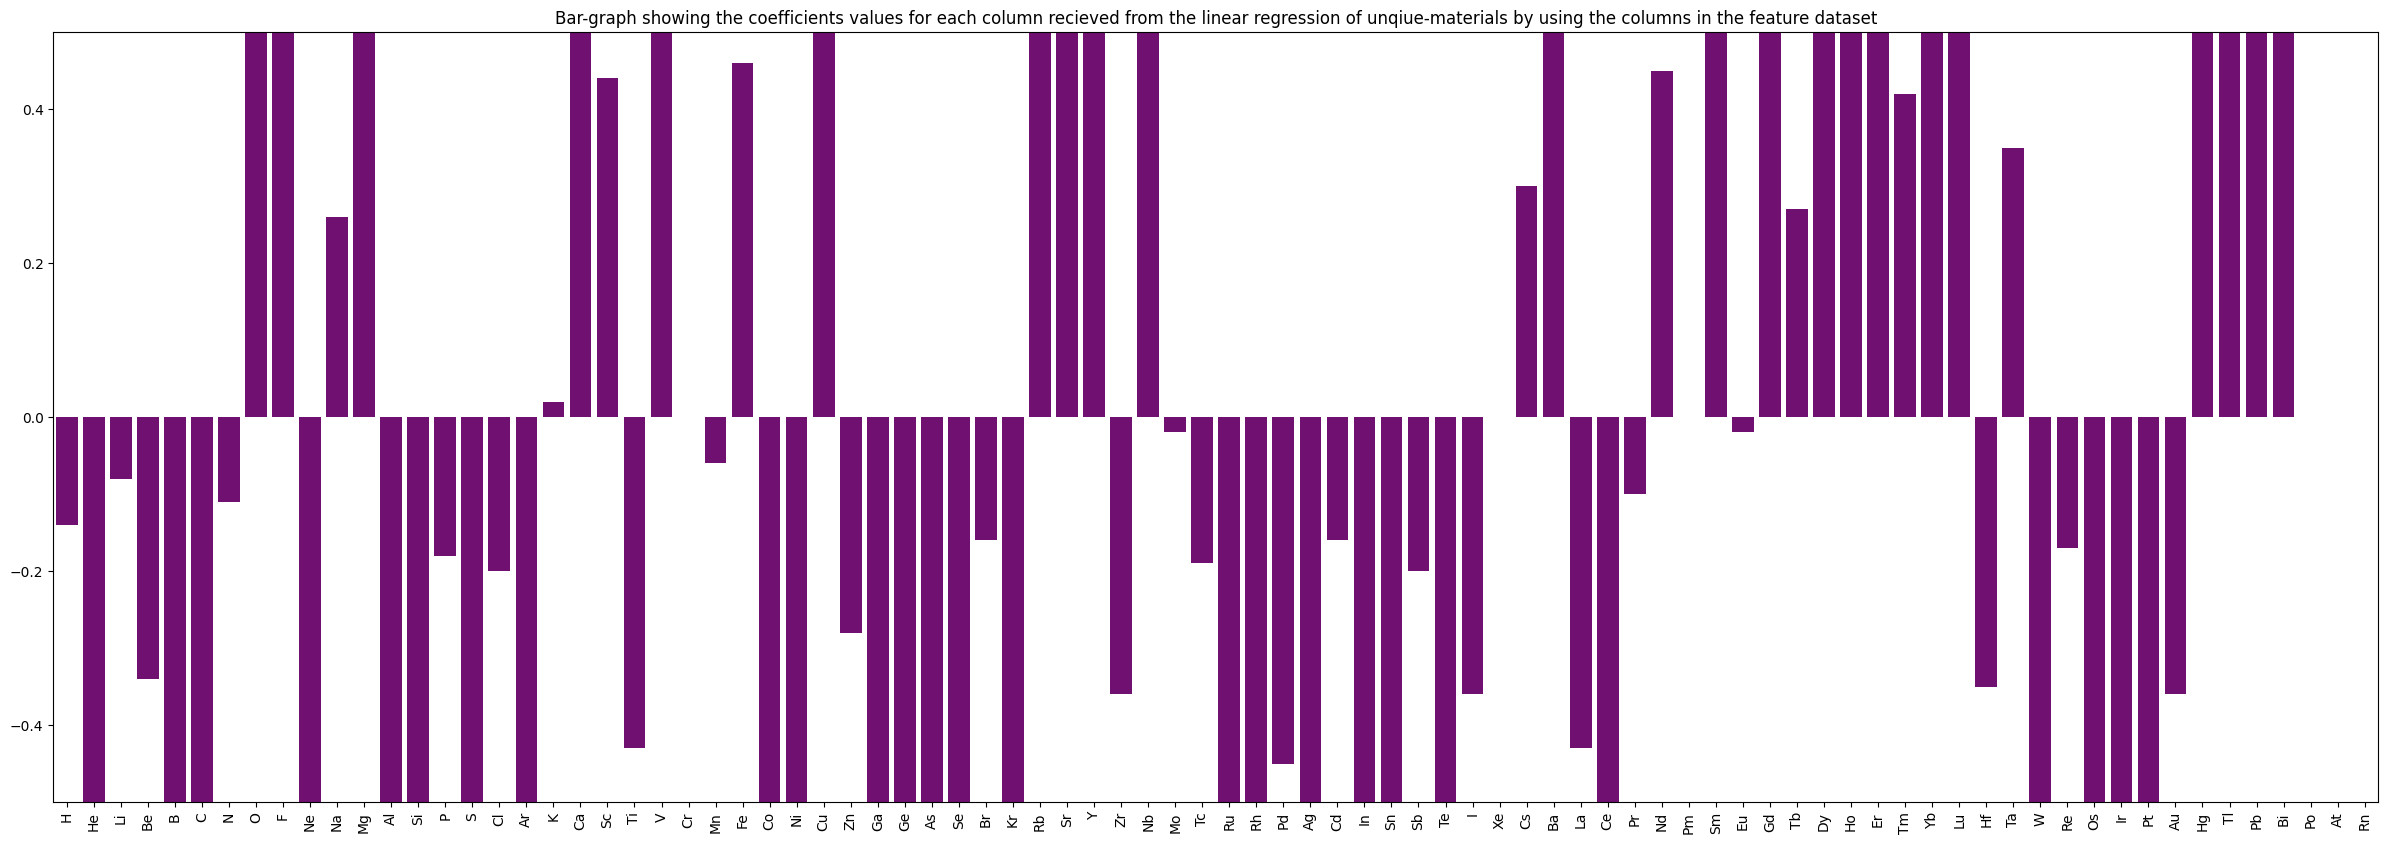

In [132]:
#Extracting the coefficient values of the linear regression model trained using the unique materials
coefficients_linear_regression_for_unique_materials = linearRegressionModel_uniqueMaterials.coef_[0]
coefficients_linear_regression_for_unique_materials = [ float( "{:.2f}".format( x ) ) for x in coefficients_linear_regression_for_unique_materials ]
#Printing the coefficients of the linear regression model for the unique materials
print( coefficients_linear_regression_for_unique_materials )
#Plotting the coeffiecients in form of a bar-graph
plt.figure( figsize = ( 30,10 ) )
plt.title( "Bar-graph showing the coefficients values for each column recieved from the linear regression of unqiue-materials by using the columns in the feature dataset" )
plt.ylim( -0.5,0.5 )
plt.xticks( ticks = np.arange( 0, len( coefficients_linear_regression_for_unique_materials ), step = 1  ), labels = unique_materials_features_dataset.columns.values, rotation='vertical')
#Plotting the bar-plot
sns.barplot( x = unique_materials_features_dataset.columns.values , y = coefficients_linear_regression_for_unique_materials, color = "purple" )

## Using Decision Tree Regressor to see the performance of the model using all the elements i.e. features to get the RMSE score while predicting the Critical_Temperature.

In [133]:
#Using a Decision Tree Regressor to predict so that we can get the best scores
decisionTreeRegressor = DecisionTreeRegressor()
#Training the model
decisionTreeRegressor.fit( unique_materials_df_X_train, unique_materials_df_y_train )
#Getting the predictions from the decision Tree Regressor
predictions_decision_tree_regressor = decisionTreeRegressor.predict( unique_materials_df_X_test )
##Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( predictions_decision_tree_regressor, unique_materials_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 11.576726207855234


In [135]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( predictions_decision_tree_regressor, unique_materials_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.8843317353731691


## Using Polynomial Regression Classifier to see the performance of the model using all the elements i.e. features to get the RMSE score while predicting the Crtitical Temperature.

In [136]:
#Trying polynomial regression to see if the features could be improved
polynomialFeatures_uniqueMaterials = PolynomialFeatures( degree = 2, include_bias=False )
#Fitting the polynomial feaures onto the training features dataset
unique_materials_df_X_train_scaled = polynomialFeatures.fit_transform( unique_materials_df_X_train_scaled )
#Fitting the polynomial features onto the testing features dataset
unique_materials_df_X_test_scaled = polynomialFeatures.fit_transform( unique_materials_df_X_test_scaled )
#Creating a object of the Linear Regression that will train on these properties
linearRegressionModel_uniqueMaterials = LinearRegression()
#Training the model
linearRegressionModel_uniqueMaterials.fit( unique_materials_df_X_train_scaled, unique_materials_df_y_train )
#Getting the predictions output from the model
linearModelPredictions_uniqueMaterials = linearRegressionModel_uniqueMaterials.predict( unique_materials_df_X_test_scaled )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( linearModelPredictions_uniqueMaterials, unique_materials_df_y_test, squared= False )
print( f"The mean_squared_error_values using all the features is { mean_squared_error_values }" )

The mean_squared_error_values using all the features is 4615567324778.219


Since, the correlation values for few columns were coming up as extremely high, on observing the dataset, the dataset was observed for any anomaly of a behaviour. It was observed that most of the properties have a value of 0 which was might have caused the Linear Regression Model to not get trained model properly and the co-efficients value receiving a very high number. Furthermore, this could have been acheived by "Variance-Filter" feature selection criteria but since we decided to first go with the "correlation", this aspect of the materials was missed

In [137]:
#Extracting the variance of the unique materials dataframe
variance_of_features_of_unique_materials_dataframe = unique_materials_features_dataset.var()
#Printing the variances
print( variance_of_features_of_unique_materials_dataframe.head() )
#Creating a list where we can store the elements with zero variance
elements_with_zero_variance = []
#Getting the elements names with zero variance
for index in variance_of_features_of_unique_materials_dataframe.index:
  if( variance_of_features_of_unique_materials_dataframe[ index ] == 0.00 ):
    elements_with_zero_variance.append( index )
#Printing the elements with zero variance
print( "The elements list with zero variance is" )
print( elements_with_zero_variance )

H     0.071406
He    0.000000
Li    0.016784
Be    0.720022
B     1.090951
dtype: float64
The elements list with zero variance is
['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn']


In [138]:
#Getting the indexes of the features who have at least > +0.5 co-relation value and < -0.5 co-realtion value
first_filter_significant_columns_for_unique_materials = []
for coefficients, column in zip( coefficients_linear_regression_for_unique_materials, unique_materials_features_dataset.columns.values.tolist() ):
  if( ( not column in elements_with_zero_variance ) and (coefficients >= 0.5 or coefficients <= -0.5) ):
    first_filter_significant_columns_for_unique_materials.append( column )
#Printing the significant_columns length
print( f"The number of significantly co-related columns for unique materials are { len( first_filter_significant_columns_for_unique_materials ) }" )
#Printing the significant columns
print( first_filter_significant_columns_for_unique_materials )

The number of significantly co-related columns for unique materials are 44
['B', 'C', 'O', 'F', 'Mg', 'Al', 'Si', 'S', 'Ca', 'V', 'Co', 'Ni', 'Cu', 'Ga', 'Ge', 'As', 'Se', 'Rb', 'Sr', 'Y', 'Nb', 'Ru', 'Rh', 'Ag', 'In', 'Sn', 'Te', 'Ba', 'Ce', 'Sm', 'Gd', 'Dy', 'Ho', 'Er', 'Yb', 'Lu', 'W', 'Os', 'Ir', 'Pt', 'Hg', 'Tl', 'Pb', 'Bi']


In [139]:
#Taking the subset of these elements from the unique materials column and then creating the Linear Regression Model and seeing if the model is able to predict well
unique_materials_features_dataset= unique_materials_features_dataset[ first_filter_significant_columns_for_unique_materials ]
#Printing the feature variables dataset after the first round of selection
print( unique_materials_features_dataset.head() )

     B    C    O    F   Mg   Al   Si    S   Ca    V  ...   Yb   Lu    W   Os  \
0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    Ir   Pt   Hg   Tl   Pb   Bi  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 44 columns]


In [140]:
#Splitting the dataset into training and testing dataset and running the linear regression model. By this method we will also be able to get the co-efficients of the elements
#and identify how each element behave with the critical_temp.
unique_materials_df_X_train, unique_materials_df_X_test, unique_materials_df_y_train, unique_materials_df_y_test = train_test_split( unique_materials_features_dataset, unique_materials_response_dataset, test_size=0.33, random_state=42 )
#Printing the shape of the training and testing dataset so as to ensure that everything is correct
print( f"The shape of the feature variable in the training dataset is {unique_materials_df_X_train.shape}" )
print( f"The shape of the response variable in the training dataset is {unique_materials_df_y_train.shape}")
print( f"The shape of the feature variable in the testing dataset is {unique_materials_df_X_test.shape}" )
print( f"The shape of the response variable in the testing dataset is {unique_materials_df_y_test.shape}")

The shape of the feature variable in the training dataset is (14246, 44)
The shape of the response variable in the training dataset is (14246, 1)
The shape of the feature variable in the testing dataset is (7017, 44)
The shape of the response variable in the testing dataset is (7017, 1)


In [141]:
#Creating a scaler object of standard scaler
standardScaler = StandardScaler()
#Scaling the features training dataset and testing dataset
#Scaling the features training dataset
unique_materials_df_X_train_scaled =  standardScaler.fit_transform( unique_materials_df_X_train )
#Scaling the features test dataset
unique_materials_df_X_test_scaled = standardScaler.fit_transform( unique_materials_df_X_test )

## Linear Regression Model trained on the elements that don't have zero variance

In [142]:
#creating a object of linear Regression
linearRegressionModel_uniqueMaterials = LinearRegression()
#Training the model
linearRegressionModel_uniqueMaterials.fit( unique_materials_df_X_train_scaled, unique_materials_df_y_train )
#Predicting the model outcome
linearModelPredictions_uniqueMaterials = linearRegressionModel_uniqueMaterials.predict( unique_materials_df_X_test_scaled )
#Getting the RMSE score of the model
#Getting the RMSE scores
mean_squared_error_value_unique_materials = metrics.mean_squared_error( linearModelPredictions_uniqueMaterials, unique_materials_df_y_test, squared= False )
#Printing the mean squared error values
print( f" The mean squared error value is { mean_squared_error_value_unique_materials }" )

 The mean squared error value is 20.30637497332086


## Decision Tree Regressor Model trained on the elements that don't have zero variance

In [143]:
#Using a Decision Tree Regressor to predict so that we can get the best scores
decisionTreeRegressor = DecisionTreeRegressor()
#Training the model
decisionTreeRegressor.fit( unique_materials_df_X_train, unique_materials_df_y_train )
#Getting the predictions from the decision Tree Regressor
predictions_decision_tree_regressor = decisionTreeRegressor.predict( unique_materials_df_X_test )
##Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( predictions_decision_tree_regressor, unique_materials_df_y_test, squared= False )
#Converting the RMSE values to a dataframe
#mean_squared_error_values_df = pd.DataFrame( mean_squared_error_values, columns=["error_value"] )
#Printing the mean squared error values
print( f"The mean_squared_error_values using this set of features is { mean_squared_error_values }" )

The mean_squared_error_values using this set of features is 13.067903755121675


In [144]:
#Printing the R^2 score of the classifier
r_square_value = metrics.r2_score( predictions_decision_tree_regressor, unique_materials_df_y_test )
print( f"The r_square_value of this feature of subset is { r_square_value }" )

The r_square_value of this feature of subset is 0.8495949311727087


It can be observed that with the elements, the Decision Tree Regressor performs slightly better with a **RMSE** error value of ```13.06``` and **R^2** score of ```84.95```.

## Polynomial Regression Model trained on the model that don't have zero variance

In [145]:
#Trying polynomial regression to see if the features could be improved
polynomialFeatures_uniqueMaterials = PolynomialFeatures( degree = 2, include_bias=False )
#Fitting the polynomial feaures onto the training features dataset
unique_materials_df_X_train_scaled = polynomialFeatures.fit_transform( unique_materials_df_X_train_scaled )
#Fitting the polynomial features onto the testing features dataset
unique_materials_df_X_test_scaled = polynomialFeatures.fit_transform( unique_materials_df_X_test_scaled )
#Creating a object of the Linear Regression that will train on these properties
linearRegressionModel_uniqueMaterials = LinearRegression()
#Training the model
linearRegressionModel_uniqueMaterials.fit( unique_materials_df_X_train_scaled, unique_materials_df_y_train )
#Getting the predictions output from the model
linearModelPredictions_uniqueMaterials = linearRegressionModel_uniqueMaterials.predict( unique_materials_df_X_test_scaled )
#Getting the RMSE scores
mean_squared_error_values = metrics.mean_squared_error( linearModelPredictions_uniqueMaterials, unique_materials_df_y_test, squared= False )
print( f"The mean_squared_error_values using all the features is { mean_squared_error_values }" )

The mean_squared_error_values using all the features is 68908710212.88933


In [146]:
#Trying to see if we have collinearity in the dataset by using the feature varaibles dataset
#Adding a constant column so that we can get the actual VIF factor as the VIF factor assumes a constant in the calculation
#atomic_properties_filtered.loc[:,"constant_column"] = 1
#Printing the column values
unique_materials_features_dataset_constant = add_constant( unique_materials_features_dataset )
#Printing the columns in the constant_columns
#print( unique_materials_features_dataset_constant.info() )
unique_materials_multicollinear = pd.Series([variance_inflation_factor(  unique_materials_features_dataset_constant.values, i)
for i in range(  unique_materials_features_dataset_constant.shape[1])],
              index=unique_materials_features_dataset_constant.columns)
#Printing the series
print( unique_materials_multicollinear )
#Looking at the data, it can be observed that the properties aren't multicollinear in nature.

const    2.497138
B        1.178182
C        1.361183
O        2.399395
F        1.058505
Mg       1.294999
Al       1.033728
Si       1.372765
S        1.038103
Ca       2.060387
V        1.289725
Co       1.010494
Ni       1.014472
Cu       1.991632
Ga       1.482347
Ge       1.182285
As       1.948836
Se       1.020520
Rb       1.355338
Sr       2.139204
Y        1.336142
Nb       1.276414
Ru       1.007888
Rh       1.024714
Ag       1.049584
In       1.190949
Sn       1.068059
Te       1.005072
Ba       2.713425
Ce       1.217029
Sm       1.018193
Gd       1.065025
Dy       1.021174
Ho       1.023121
Er       1.035217
Yb       1.026612
Lu       1.105973
W        1.010957
Os       1.045780
Ir       1.214066
Pt       1.531169
Hg       1.101996
Tl       1.078851
Pb       1.037573
Bi       1.519806
dtype: float64


### Instad of doing the same cycle of feature selection over and over and analyzing the RMSE score manually, we will be leveraging the inbuilt feature selection tools that the _scikit-learn_ package has such as "SelectFromModel" and "REFCV"

#### Using the SelectFromModel feature of the Scikit Learn using normal parameters and all of the unique elements

In [147]:
#Separating the dataset into feature variables and the response variable
#Creating the features dataframe
unique_materials_features_dataset = unique_materials_data_frame.drop( columns = ["critical_temp","material"] )
#Getting the response variable dataframe
unique_materials_response_dataset = unique_materials_data_frame[["critical_temp"]]
#Printing the features dataset
print( unique_materials_features_dataset.head() )
#Printing the response dataset
print( unique_materials_response_dataset.head() )

     H  He   Li   Be    B    C    N    O    F  Ne  ...   Ir   Pt   Au   Hg  \
0  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
1  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
2  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
3  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   
4  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...  0.0  0.0  0.0  0.0   

    Tl   Pb   Bi  Po  At  Rn  
0  0.0  0.0  0.0   0   0   0  
1  0.0  0.0  0.0   0   0   0  
2  0.0  0.0  0.0   0   0   0  
3  0.0  0.0  0.0   0   0   0  
4  0.0  0.0  0.0   0   0   0  

[5 rows x 86 columns]
   critical_temp
0           29.0
1           26.0
2           19.0
3           22.0
4           23.0


In [148]:
#Printing the length of the column of the features dataset before dropping the zero variance column
print( f"The length of the dataset-columns before dropping the zero variance columns are { len( unique_materials_features_dataset.columns ) }" )
#Updating the features column to contain only the elements that don't have zero variance
unique_materials_features_dataset = unique_materials_features_dataset.drop( columns= elements_with_zero_variance )
#Printing the length of the column of the features dataset after dropping the zero variance column
print( f"The length of the dataset-columns after dropping the zero variance columns are { len( unique_materials_features_dataset.columns ) }" )

The length of the dataset-columns before dropping the zero variance columns are 86
The length of the dataset-columns after dropping the zero variance columns are 77


In [149]:
#Splitting the dataset into training and testing dataset and running the linear regression model. By this method we will also be able to get the co-efficients of the elements
#and identify how each element behave with the critical_temp.
unique_materials_df_X_train, unique_materials_df_X_test, unique_materials_df_y_train, unique_materials_df_y_test = train_test_split( unique_materials_features_dataset, unique_materials_response_dataset, test_size=0.33, random_state=42 )
#Printing the shape of the training and testing dataset so as to ensure that everything is correct
print( f"The shape of the feature variable in the training dataset is {unique_materials_df_X_train.shape}" )
print( f"The shape of the response variable in the training dataset is {unique_materials_df_y_train.shape}")
print( f"The shape of the feature variable in the testing dataset is {unique_materials_df_X_test.shape}" )
print( f"The shape of the response variable in the testing dataset is {unique_materials_df_y_test.shape}")

The shape of the feature variable in the training dataset is (14246, 77)
The shape of the response variable in the training dataset is (14246, 1)
The shape of the feature variable in the testing dataset is (7017, 77)
The shape of the response variable in the testing dataset is (7017, 1)


In [150]:
#Creating a model of Decision Tree Regressor type and then passing the features to the model and training the model
decisionTreeRegressor_uniqueMaterials = DecisionTreeRegressor()
#Fitting the model with the training dataset feature variables and response variable
decisionTreeRegressor_uniqueMaterials.fit( unique_materials_df_X_train, unique_materials_df_y_train )
#Getting the model by using the SelectFromModel
model_with_selected_features_for_unique_materials = SelectFromModel( decisionTreeRegressor_uniqueMaterials , prefit= True )
#New Feature Training dataset
unique_materials_df_X_train = model_with_selected_features_for_unique_materials.fit_transform( unique_materials_df_X_train )
#Printing the new features training dataset
print( unique_materials_df_X_train.shape )

(14246, 7)


In [151]:
#Getting the feature names out for the model that is used to get the highest regression score for unique materials
features_name_contributing_to_unique_materials_score = model_with_selected_features_for_unique_materials.get_feature_names_out()
#Printing the features names
print( features_name_contributing_to_unique_materials_score )

['O' 'Ca' 'Cu' 'Sr' 'Ba' 'Ce' 'Pr']


In [152]:
#Taking the above seven features from the dataset and running the Decision Tree Classifier Model so as to see the RMSE score
best_feature_variables_according_to_select_from_model = unique_materials_features_dataset[ features_name_contributing_to_unique_materials_score ]
#Printing the features dataframe
print( best_feature_variables_according_to_select_from_model.head() )


     O   Ca   Cu   Sr    Ba   Ce   Pr
0  4.0  0.0  1.0  0.0  0.20  0.0  0.0
1  4.0  0.0  0.9  0.0  0.10  0.0  0.0
2  4.0  0.0  1.0  0.0  0.10  0.0  0.0
3  4.0  0.0  1.0  0.0  0.15  0.0  0.0
4  4.0  0.0  1.0  0.0  0.30  0.0  0.0


In [153]:
#Splitting the dataset into training and testing dataset and running the Decision Tree Regressor model. By this method we will also be able to get the co-efficients of the elements
#and identify how each element behave with the critical_temp.
unique_materials_df_X_train, unique_materials_df_X_test, unique_materials_df_y_train, unique_materials_df_y_test = train_test_split( best_feature_variables_according_to_select_from_model, unique_materials_response_dataset, test_size=0.33, random_state=42 )
#Printing the shape of the training and testing dataset so as to ensure that everything is correct
print( f"The shape of the feature variable in the training dataset is {unique_materials_df_X_train.shape}" )
print( f"The shape of the response variable in the training dataset is {unique_materials_df_y_train.shape}")
print( f"The shape of the feature variable in the testing dataset is {unique_materials_df_X_test.shape}" )
print( f"The shape of the response variable in the testing dataset is {unique_materials_df_y_test.shape}")

The shape of the feature variable in the training dataset is (14246, 7)
The shape of the response variable in the training dataset is (14246, 1)
The shape of the feature variable in the testing dataset is (7017, 7)
The shape of the response variable in the testing dataset is (7017, 1)


In [154]:
#creating a object of Decision Tree Regressor
decisionTreeRegressor_uniqueMaterials = DecisionTreeRegressor()
#Training the model
decisionTreeRegressor_uniqueMaterials.fit( unique_materials_df_X_train_scaled, unique_materials_df_y_train )
#Predicting the model outcome
decisionTreeRegressor_uniqueMaterials = decisionTreeRegressor_uniqueMaterials.predict( unique_materials_df_X_test_scaled )
#Getting the RMSE score of the model
#Getting the RMSE scores
mean_squared_error_value_unique_materials = metrics.mean_squared_error( decisionTreeRegressor_uniqueMaterials, unique_materials_df_y_test, squared= False )
#Printing the mean squared error values
print( f" The mean squared error value is { mean_squared_error_value_unique_materials }" )

 The mean squared error value is 18.300730694908346


### Using Recursive Feature Selection with Cross-Validation to see which are the best elements for predicting the Critical Temperature

In [156]:
#Creating a cross-validation estimator
cross_validation_estimator = DecisionTreeRegressor()
#Fitting the estimator with the training data
cross_validation_estimator.fit( unique_materials_df_X_train, unique_materials_df_y_train )
#Creating the feature selector
element_selector_cross_validation = RFECV( cross_validation_estimator, cv= 5, step=1, scoring='r2')
#Fitting the training data
element_selector_cross_validation = element_selector_cross_validation.fit( unique_materials_df_X_train, unique_materials_df_y_train )

In [157]:
element_selector_cross_validation_support = element_selector_cross_validation.get_support()
best_unique_elements = []
for bool, elements in zip( element_selector_cross_validation_support , unique_materials_df_X_train.columns):
  if bool:
    best_unique_elements.append( elements )
print(f"Best features are:{ best_unique_elements }")

Best features are:['O', 'Ca', 'Cu', 'Sr', 'Ba', 'Ce', 'Pr']
